#Pojet Image Classification : Dogs Breeds

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
import tensorflow as tf 
print(tf.__version__)

2.4.1


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Mar 26 02:11:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
pip install wget

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.io as sp
import tensorflow 
from sklearn.metrics import roc_curve 
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import imagenet_utils
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline

In [3]:
import os
import scipy.io
import glob
import re
import shutil
import itertools
import requests
import json
import wget
from pathlib import Path
from matplotlib.image import imread
from PIL import Image
import random


## paths setting

In [4]:
os.getcwd()

'/content'

In [5]:
path_source = '/content/drive/MyDrive/datasets/Images/'
path_destination = '/content/drive/MyDrive/datasets/data/'
path_data = '/content/drive/MyDrive/datasets/data/'
path_datasets ='/content/drive/MyDrive/datasets/'

In [ ]:
os.makedirs('/content/drive/MyDrive/datasets/data/')

In [ ]:
# Changement de répertoire de travail
os.chdir(path_data)
os.makedirs('train/')
os.makedirs('valid/')
os.makedirs('test/')

In [ ]:
os.listdir()

['train', 'valid', 'test']

In [ ]:
import tarfile
tar = tarfile.open(path_datasets+'images.tar', 'r')
tar.extractall(path_datasets)
tar.close()

In [6]:
#races_ = name_labels
races_ = [re.sub("n[0-9]*-", "", file_breed.name) for file_breed in os.scandir(path_source) if file_breed.is_dir()]
races_

['English_springer',
 'Welsh_springer_spaniel',
 'cocker_spaniel',
 'kuvasz',
 'schipperke',
 'groenendael',
 'briard',
 'kelpie',
 'Old_English_sheepdog',
 'collie',
 'Border_collie',
 'Rottweiler',
 'German_shepherd',
 'miniature_pinscher',
 'Greater_Swiss_Mountain_dog',
 'Bernese_mountain_dog',
 'Appenzeller',
 'boxer',
 'bull_mastiff',
 'Tibetan_mastiff',
 'Saint_Bernard',
 'Eskimo_dog',
 'malamute',
 'Siberian_husky',
 'pug',
 'Great_Pyrenees',
 'Pomeranian',
 'chow',
 'keeshond',
 'Brabancon_griffon',
 'Pembroke',
 'Cardigan',
 'toy_poodle',
 'miniature_poodle',
 'standard_poodle',
 'Mexican_hairless',
 'dingo',
 'Irish_water_spaniel',
 'Sussex_spaniel',
 'malinois',
 'Bouvier_des_Flandres',
 'komondor',
 'Doberman',
 'EntleBucher',
 'Great_Dane',
 'affenpinscher',
 'Leonberg',
 'basenji',
 'Newfoundland',
 'Samoyed',
 'dhole',
 'African_hunting_dog',
 'English_foxhound',
 'otterhound',
 'Shetland_sheepdog',
 'French_bulldog',
 'Chihuahua',
 'Japanese_spaniel',
 'Maltese_dog',
 '

In [10]:
len(races_)

120

In [ ]:
#retourner le nombre d'images presentes dans le fichier images peu importe la race 
images = [filespath for filespath in glob.glob(path_source + "*/*")]

len(images)

20580

In [ ]:
#EXECUTE ICI : GENERALISATION 
def moveImages (file_breed, path, percent) :
  file_breed_destination = path_destination+path+re.sub("n[0-9]*-","",file_breed.name)

  os.makedirs(file_breed_destination, exist_ok=True)

  file_breed_images = os.listdir(file_breed)

  for file in random.sample(file_breed_images, int(len(file_breed_images)*percent)):
    shutil.move(path_source+file_breed.name+"/"+file, file_breed_destination+"/"+re.sub("n[0-9]*_","",file))
  return()

In [ ]:
#train , 70%
for file_breed in os.scandir(path_source):
  moveImages(file_breed, 'train/', 0.7)

In [ ]:
#valid 20%%

for file_breed in os.scandir(path_source):
  moveImages(file_breed, 'valid/', 0.7)

In [ ]:
#test 20%%

for file_breed in os.scandir(path_source):
  moveImages(file_breed, 'test/', 1)

In [ ]:
path_train = path_destination +'/train'
os.listdir(path_train)
nb_train = os.listdir(path_train)

In [ ]:
path_valid = path_destination +'/valid'
os.listdir(path_valid)
nb_valid = os.listdir(path_valid)

In [ ]:
len(nb_valid)

120

In [ ]:
len(nb_train)

120

# Building test set from Dog API

In [ ]:
response = requests.get("https://dog.ceo/api/breeds/image/random/600")

response.json()

{'message': ['https://images.dog.ceo/breeds/terrier-westhighland/n02098286_43.jpg',
  'https://images.dog.ceo/breeds/terrier-norwich/n02094258_2525.jpg',
  'https://images.dog.ceo/breeds/bullterrier-staffordshire/n02093256_5295.jpg',
  'https://images.dog.ceo/breeds/terrier-irish/n02093991_837.jpg',
  'https://images.dog.ceo/breeds/pointer-germanlonghair/hans2.jpg',
  'https://images.dog.ceo/breeds/weimaraner/n02092339_6124.jpg',
  'https://images.dog.ceo/breeds/collie-border/n02106166_2961.jpg',
  'https://images.dog.ceo/breeds/terrier-dandie/n02096437_1532.jpg',
  'https://images.dog.ceo/breeds/coonhound/n02089078_3355.jpg',
  'https://images.dog.ceo/breeds/basenji/n02110806_1369.jpg',
  'https://images.dog.ceo/breeds/ovcharka-caucasian/IMG_20191108_140150.jpg',
  'https://images.dog.ceo/breeds/samoyed/n02111889_3221.jpg',
  'https://images.dog.ceo/breeds/germanshepherd/n02106662_25986.jpg',
  'https://images.dog.ceo/breeds/pug/n02110958_15364.jpg',
  'https://images.dog.ceo/breeds/h

In [ ]:
list = response.json()
liens = list['message']
print(list['message'])

['https://images.dog.ceo/breeds/terrier-westhighland/n02098286_43.jpg', 'https://images.dog.ceo/breeds/terrier-norwich/n02094258_2525.jpg', 'https://images.dog.ceo/breeds/bullterrier-staffordshire/n02093256_5295.jpg', 'https://images.dog.ceo/breeds/terrier-irish/n02093991_837.jpg', 'https://images.dog.ceo/breeds/pointer-germanlonghair/hans2.jpg', 'https://images.dog.ceo/breeds/weimaraner/n02092339_6124.jpg', 'https://images.dog.ceo/breeds/collie-border/n02106166_2961.jpg', 'https://images.dog.ceo/breeds/terrier-dandie/n02096437_1532.jpg', 'https://images.dog.ceo/breeds/coonhound/n02089078_3355.jpg', 'https://images.dog.ceo/breeds/basenji/n02110806_1369.jpg', 'https://images.dog.ceo/breeds/ovcharka-caucasian/IMG_20191108_140150.jpg', 'https://images.dog.ceo/breeds/samoyed/n02111889_3221.jpg', 'https://images.dog.ceo/breeds/germanshepherd/n02106662_25986.jpg', 'https://images.dog.ceo/breeds/pug/n02110958_15364.jpg', 'https://images.dog.ceo/breeds/hound-basset/n02088238_9324.jpg', 'https:

In [ ]:
for lien in liens:
    wget.download(lien,path_test)

# Data generation

In [25]:
#paths
path_test = path_destination +'test/'
path_test

'/content/drive/MyDrive/datasets/data/test/'

In [26]:
path_train = path_destination +'train/'
path_train

'/content/drive/MyDrive/datasets/data/train/'

In [27]:
path_valid = path_destination +'valid/'
path_valid

'/content/drive/MyDrive/datasets/data/valid/'

In [28]:
#scale entre 0 et 1
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [29]:
train_gen = train_datagen.flow_from_directory(
    path_train, # path du train 
    target_size=(150, 150), #image reshaping
    batch_size=20, 
    class_mode='categorical'
)

Found 14355 images belonging to 120 classes.


In [30]:
val_gen = val_datagen.flow_from_directory(
    path_valid, 
    target_size=(150, 150), 
    batch_size=20, 
    class_mode='categorical'
)

Found 4302 images belonging to 120 classes.


In [31]:
test_gen = test_datagen.flow_from_directory(
    path_test,
    target_size=(150,150),  
    batch_size=20,
    shuffle=False)
#shuffle : becasue later when we test our model , we want to have acces to unshuffled labels to plot our confusion matrix , by defaut
#defaullt, shuffle is set to True 

Found 1923 images belonging to 120 classes.


In [ ]:
type(val_gen)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [32]:
#nb_class = classes
nb_train = train_gen.num_classes
nb_class= nb_train 
nb_class

120

In [33]:
def diagnostic_learning_curves(history):
    
    # Retrieve a list of accuracy results on training and validation data sets for each training epoch
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Retrieve a list of list results on training and validation data sets for each training epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Get number of epochs
    epochs = range(1, len(loss) + 1)

    # Plot training and validation accuracy per epoch
    plt.figure(figsize = (20, 10))
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper left')
    
    plt.figure(figsize = (20, 10))
    # Plot training and validation loss per epoch
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc = 'upper right')

# CNN 

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

### model_1 : from scratch

In [34]:
#def get_model():
inputs = tf.keras.layers.Input(shape=(150, 150, 3))
tf.keras.layers.Conv2D
#16 neuronnes d'activation  et un flitre de (3,3) on peut aussir ecrire 3 simplement
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Conv2D(64, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2)(x)

x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(512, activation='relu')(x)

outputs = tf.keras.layers.Dense(120, activation='sigmoid')(x)

model_1 = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    #return model_1


In [35]:
#model_1 = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0   

RMSprop : https://keras.io/api/optimizers/rmsprop/

In [ ]:
#model_1= get_model()

In [36]:
from tensorflow.keras.optimizers import RMSprop
model_1.compile (loss='categorical_crossentropy',
               optimizer = RMSprop(lr=0.001) ,metrics=['accuracy'])

In [37]:
print("Fit model on training data : ")
history_1= model_1.fit(
     train_gen, epochs= 5,
    steps_per_epoch = len(train_gen),
    validation_data = val_gen,
    validation_steps = len(val_gen),
    verbose = 2)

#verbose=2 
#ensuite  essaye epochs = 5

Fit model on training data : 
Epoch 1/5
718/718 - 76s - loss: 4.6247 - accuracy: 0.0258 - val_loss: 4.3314 - val_accuracy: 0.0490
Epoch 2/5
718/718 - 75s - loss: 4.0407 - accuracy: 0.1009 - val_loss: 4.1834 - val_accuracy: 0.0762
Epoch 3/5
718/718 - 75s - loss: 3.0553 - accuracy: 0.2821 - val_loss: 4.4759 - val_accuracy: 0.0941
Epoch 4/5
718/718 - 76s - loss: 1.4623 - accuracy: 0.6323 - val_loss: 5.8283 - val_accuracy: 0.0927
Epoch 5/5
718/718 - 75s - loss: 0.3969 - accuracy: 0.8965 - val_loss: 9.9302 - val_accuracy: 0.0869


In [ ]:
#model_1.save("my_model1")

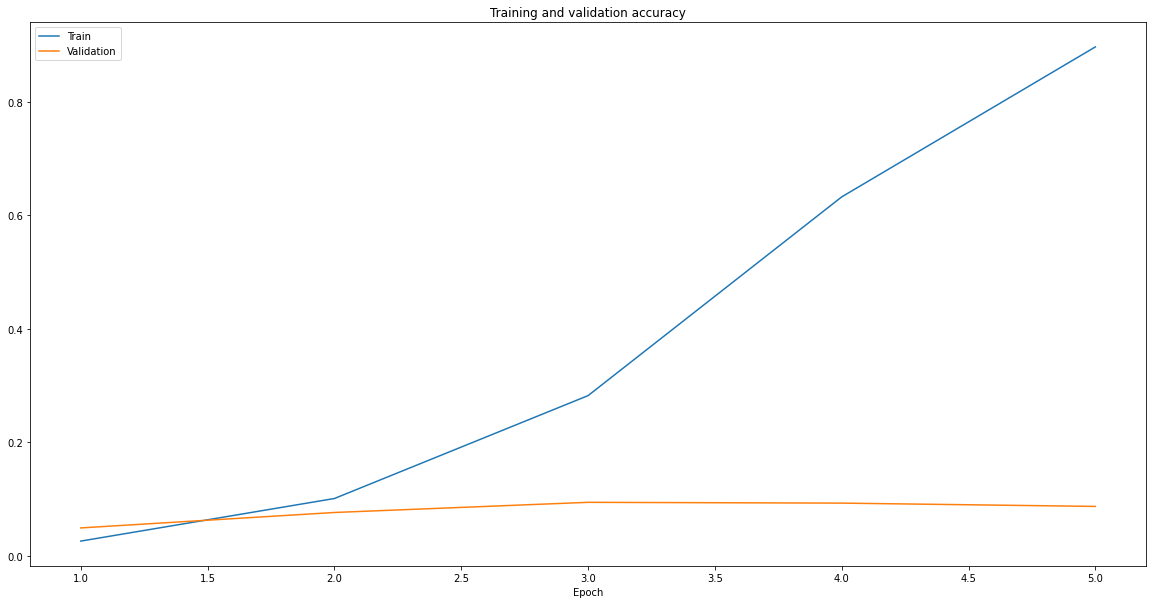

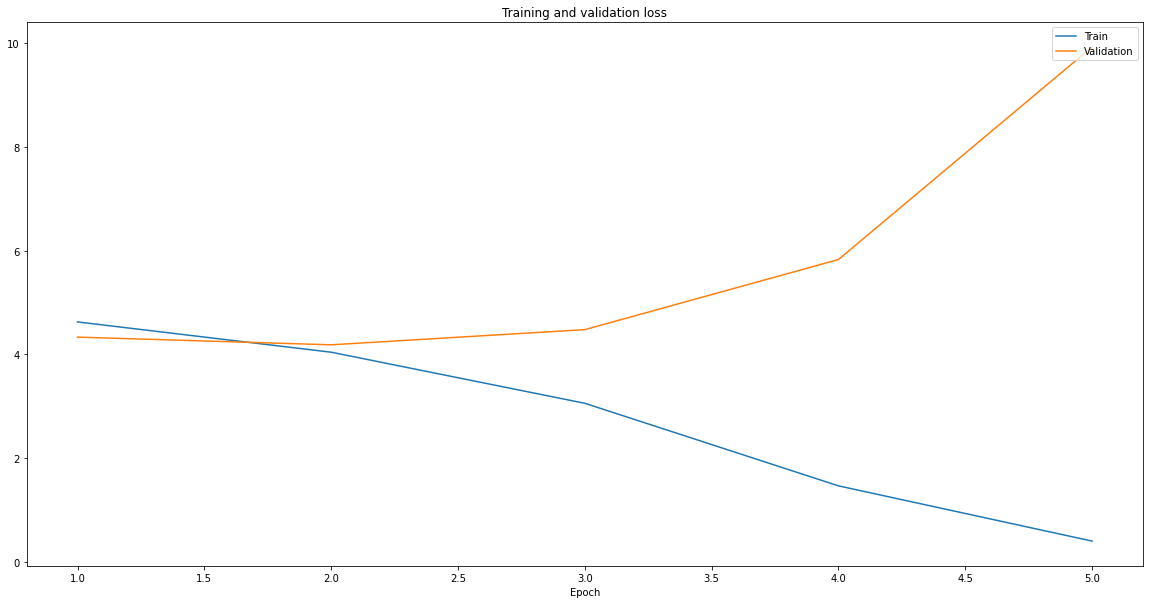

In [38]:
diagnostic_learning_curves(history_1)

In [39]:
#ne pas executer
def test_set (image_size,batch_size):
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

    test_gen = test_datagen.flow_from_directory(
    path_test,
    target_size=image_size,  # All images  from the API will be resized to image_size
    batch_size=batch_size,
    shuffle=False)

    return (test_gen)


## Définition des métriques 

In [ ]:
count = 0
for k,v in test_gen.class_indices.items():
    count+=1
    print(k)
    print(v)
    if(count==5):
     break

Afghan_hound
0
African_hunting_dog
1
Airedale
2
American_Staffordshire_terrier
3
Appenzeller
4


In [ ]:
#
test_labels = test_gen.classes
nb_class = test_gen.num_classes

In [40]:
#print les resultats de l'inference sur le model tuned
def inference (model,test_gen):
  
  test_labels = test_gen.classes
  nb_class = test_gen.num_classes #classes
  
  predictions = model.predict (x=test_gen,steps=len(test_gen),verbose=0)
  cm = confusion_matrix(y_true=test_labels,y_pred=predictions.argmax(axis=1))

  #Récupération des class labels 
  name_labels = []
  for k,v in test_gen.class_indices.items():
    #pour chaque k classe et v index
    #name_labels c'est la liste des races
    name_labels.append(k)

  #True Positive et False Positive par classes
  TP_FP = np.sum(cm,axis=0)

  #True Positive by classes
  TP = np.zeros(nb_class)
  for i in range (nb_class):
    TP[i] = (cm[i,i])

  #Accuracy per class
  accuracy =(TP/TP_FP*100).round()

  print ("Total True Positives for all classes :",TP.sum() )
  print ("Total predictions for all classes :",TP_FP.sum() )
  print ('Accuracy of predictions for all classes :',(TP.sum()/TP_FP.sum()*100).round(1))
  print ("accuracy.mean ",accuracy.mean().round(1))
  print ("accuracy.min",accuracy.min().round(1))
  print ("accuracy.max",accuracy.max().round(1))
  print ("accuracy.std",accuracy.std().round(1))

  acc_df = pd.DataFrame(accuracy.reshape(1,nb_class),columns=name_labels).transpose()
  acc_df.columns=["Accuracy"]

  acc_df.loc["Total True Positives for all classes"] = [TP.sum()]
  acc_df.loc["Total predictions for all classes"] = [TP_FP.sum()]
  acc_df.loc["Accuracy of predictions for all classes"] = [(TP.sum()/TP_FP.sum()*100).round(1)]
  acc_df.loc["accuracy.mean"] = [accuracy.mean().round(1)]
  acc_df.loc["accuracy.min"] = [accuracy.min().round(1)]
  acc_df.loc["accuracy.max"] = [accuracy.max().round(1)]
  acc_df.loc["accuracy.std"] = [accuracy.std().round(1)]
  
  return (acc_df)

In [41]:
inference_ = inference (model_1,test_gen)

Total True Positives for all classes : 33.0
Total predictions for all classes : 1923
Accuracy of predictions for all classes : 1.7
accuracy.mean  nan
accuracy.min nan
accuracy.max nan
accuracy.std nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [43]:
inference_.tail(10) 

Accuracy
vizsla                                        0.0
whippet                                       0.0
wire-haired_fox_terrier                       0.0
Total True Positives for all classes         33.0
Total predictions for all classes          1923.0
Accuracy of predictions for all classes       1.7
accuracy.mean                                 NaN
accuracy.min                                  NaN
accuracy.max                                  NaN
accuracy.std                                  NaN

# metrics

In [44]:
#The returned "history" object holds a record of the loss values and metric values during training:
history_1.history

{'accuracy': [0.025844654068350792,
  0.1008707731962204,
  0.2821316719055176,
  0.6322535872459412,
  0.8964820504188538],
 'loss': [4.624660968780518,
  4.040670394897461,
  3.0553176403045654,
  1.462315559387207,
  0.39687928557395935],
 'val_accuracy': [0.04904695600271225,
  0.07624360918998718,
  0.09414225816726685,
  0.09274756163358688,
  0.08693630993366241],
 'val_loss': [4.331431865692139,
  4.183407306671143,
  4.475869655609131,
  5.8282551765441895,
  9.930167198181152]}

In [45]:
history_1_df=pd.DataFrame(history_1.history)
history_1_df

loss  accuracy  val_loss  val_accuracy
0  4.624661  0.025845  4.331432      0.049047
1  4.040670  0.100871  4.183407      0.076244
2  3.055318  0.282132  4.475870      0.094142
3  1.462316  0.632254  5.828255      0.092748
4  0.396879  0.896482  9.930167      0.086936

In [46]:
inference_.to_csv(path_datasets+'/dogsAccuracy-Model_1_per.csv')
history_1_df.to_csv(path_datasets+'/lossacc-Model_1_per.csv')

## making inference on test set

showing unseen data

In [47]:
#plot the confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [48]:
#making predictions
#predictions = model.predict (x=test_batches,verbose=0)
predictions = model_1.predict (x=test_gen, steps=len(test_gen),verbose=0)

In [49]:
test_labels = test_gen.classes
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [50]:
test_gen.class_indices

{'Afghan_hound': 0,
 'African_hunting_dog': 1,
 'Airedale': 2,
 'American_Staffordshire_terrier': 3,
 'Appenzeller': 4,
 'Australian_terrier': 5,
 'Bedlington_terrier': 6,
 'Bernese_mountain_dog': 7,
 'Blenheim_spaniel': 8,
 'Border_collie': 9,
 'Border_terrier': 10,
 'Boston_bull': 11,
 'Bouvier_des_Flandres': 12,
 'Brabancon_griffon': 13,
 'Brittany_spaniel': 14,
 'Cardigan': 15,
 'Chesapeake_Bay_retriever': 16,
 'Chihuahua': 17,
 'Dandie_Dinmont': 18,
 'Doberman': 19,
 'English_foxhound': 20,
 'English_setter': 21,
 'English_springer': 22,
 'EntleBucher': 23,
 'Eskimo_dog': 24,
 'French_bulldog': 25,
 'German_shepherd': 26,
 'German_short-haired_pointer': 27,
 'Gordon_setter': 28,
 'Great_Dane': 29,
 'Great_Pyrenees': 30,
 'Greater_Swiss_Mountain_dog': 31,
 'Ibizan_hound': 32,
 'Irish_setter': 33,
 'Irish_terrier': 34,
 'Irish_water_spaniel': 35,
 'Irish_wolfhound': 36,
 'Italian_greyhound': 37,
 'Japanese_spaniel': 38,
 'Kerry_blue_terrier': 39,
 'Labrador_retriever': 40,
 'Lakelan

In [59]:
cm_plot_labels=[test_gen.class_indices]

In [60]:
#visualizing the prediction result using a confusion matrix
#cm = confusion_matrix(y_true=test_gen.classes, y_pred=np.argmax(predictions, axis=-1))

plot_confusion_matrix(cm=cm, classes =cm_plot_labels, normalize =False, title ='confusion matrix' )

Confusion matrix, without normalization
[[22  0  0 ...  0  0  0]
 [14  0  0 ...  0  0  0]
 [17  0  0 ...  0  0  0]
 ...
 [13  0  0 ...  0  0  0]
 [17  0  0 ...  0  0  0]
 [15  0  0 ...  0  0  0]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


# model regulation 
dropout layer

data augmentation 

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
#adding data on train_test , trying to tunne it 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        path_train,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        path_valid,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 14355 images belonging to 120 classes.
Found 4302 images belonging to 120 classes.


#Model_2 : dropout(0.5)

In [55]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Activation
#dropout
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a 120 (classes) node and softmax activation 
output = layers.Dense(120, activation='softmax')(x)

# Configure and compile the model
model_2 = Model(img_input, output)

model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 64)        0   

In [56]:
model_2.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [57]:
history_2 = model_2.fit(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=5,
      validation_data=validation_generator,
      validation_steps=len(validation_generator),
      verbose=2)
#try with verbose =2

Epoch 1/5
718/718 - 133s - loss: 4.7756 - accuracy: 0.0148 - val_loss: 4.6355 - val_accuracy: 0.0274
Epoch 2/5
718/718 - 133s - loss: 4.6178 - accuracy: 0.0247 - val_loss: 4.4250 - val_accuracy: 0.0374
Epoch 3/5
718/718 - 132s - loss: 4.5009 - accuracy: 0.0333 - val_loss: 4.3504 - val_accuracy: 0.0488
Epoch 4/5
718/718 - 132s - loss: 4.4072 - accuracy: 0.0424 - val_loss: 4.3420 - val_accuracy: 0.0453
Epoch 5/5
718/718 - 132s - loss: 4.3498 - accuracy: 0.0493 - val_loss: 4.1302 - val_accuracy: 0.0732


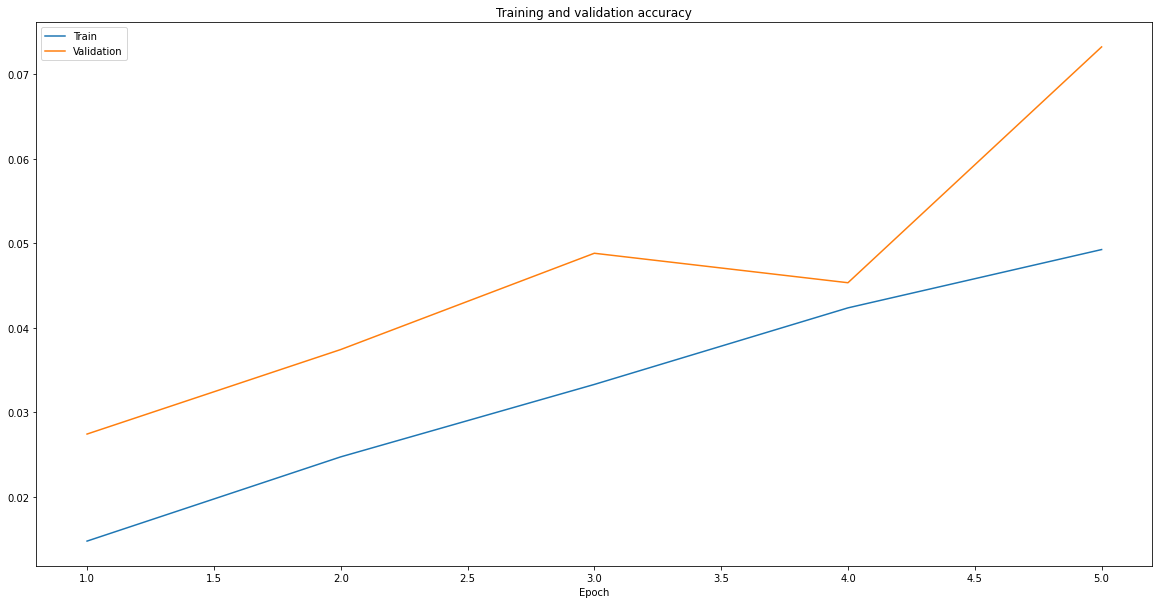

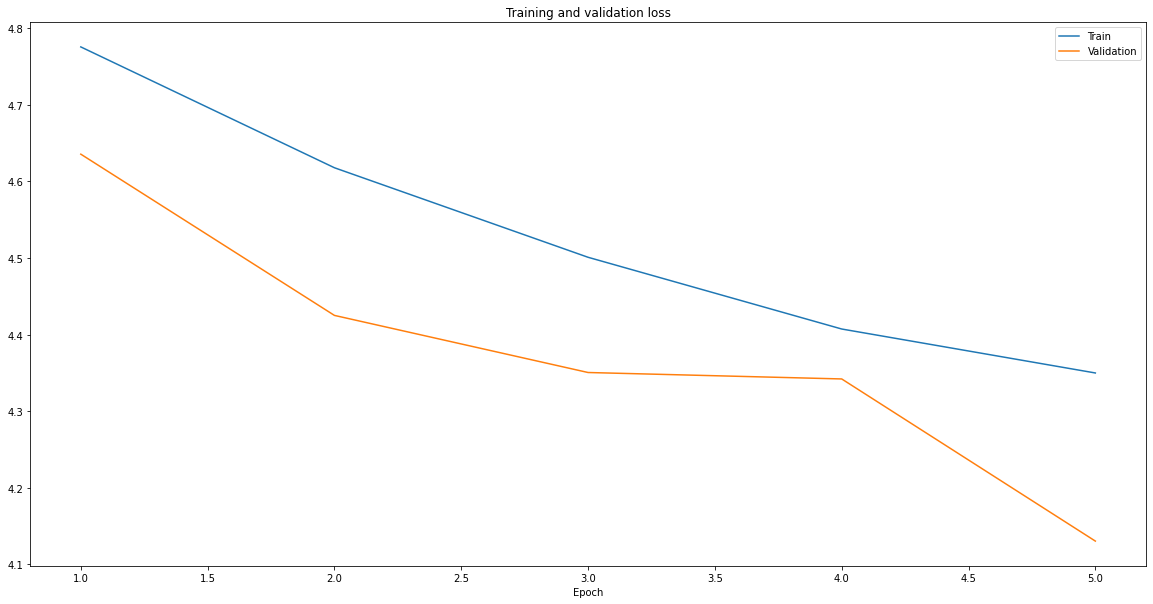

In [58]:
diagnostic_learning_curves(history_2)

#predictions 

In [61]:
#fonction pour les metrics

def inference (model,test_gen):

  test_labels = test_gen.classes #ceci corrige les bugg sur l'inference 
  
  predictions = model.predict (x=test_gen,steps=len(test_gen),verbose=0)
  cm = confusion_matrix(y_true=test_labels,y_pred=predictions.argmax(axis=1))

  nb_class = len(cm)
  #test_labels = test_gen.classes


  #Récupération des class labels 
  name_labels = []
  for k,v in test_gen.class_indices.items():
    name_labels.append(k)

  #True Positive et False Positive par classes
  TP_FP = np.sum(cm,axis=0)

  #True Positive by classes
  TP = np.zeros(len(cm))
  for i in range (len(cm)):
    TP[i] = (cm[i,i])

  #Accuracy per class
  accuracy =(TP/TP_FP*100).round()

  print ("Total True Positives for all classes :",TP.sum() )
  print ("Total predictions for all classes :",TP_FP.sum() )
  print ('Accuracy of predictions for all classes :',(TP.sum()/TP_FP.sum()*100).round(1))
  print ("accuracy.mean ",accuracy.mean().round(1))
  print ("accuracy.min",accuracy.min().round(1))
  print ("accuracy.max",accuracy.max().round(1))
  print ("accuracy.std",accuracy.std().round(1))

  acc_df = pd.DataFrame(accuracy.reshape(1,nb_class),columns=name_labels).transpose()
  acc_df.columns=["Accuracy"]

  acc_df.loc["Total True Positives for all classes"] = [TP.sum()]
  acc_df.loc["Total predictions for all classes"] = [TP_FP.sum()]
  acc_df.loc["Accuracy of predictions for all classes"] = [(TP.sum()/TP_FP.sum()*100).round(1)]
  acc_df.loc["accuracy.mean"] = [accuracy.mean().round(1)]
  acc_df.loc["accuracy.min"] = [accuracy.min().round(1)]
  acc_df.loc["accuracy.max"] = [accuracy.max().round(1)]
  acc_df.loc["accuracy.std"] = [accuracy.std().round(1)]
  
  return (acc_df)

#metrics

In [ ]:
test_labels = test_gen.classes
nb_class = test_gen.num_classes


inference_2 = inference (model_2,test_gen)

In [ ]:
inference_2.tail(10) 

NameError: ignored

In [ ]:
#The returned "history" object holds a record of the loss values and metric values during training:
history_2.history

{'accuracy': [0.013813276775181293,
  0.023970099166035652,
  0.0368083193898201,
  0.041846103966236115,
  0.04769643396139145],
 'loss': [4.768773555755615,
  4.621925354003906,
  4.490922927856445,
  4.408629417419434,
  4.358403205871582],
 'val_accuracy': [0.023595232516527176,
  0.03600097447633743,
  0.04670396447181702,
  0.0642179548740387,
  0.058866456151008606],
 'val_loss': [4.648177623748779,
  4.463919639587402,
  4.394491672515869,
  4.1898579597473145,
  4.303343296051025]}

In [ ]:
history_2_df=pd.DataFrame(history_1.history)
history_2_df

loss  accuracy   val_loss  val_accuracy
0  0.064672  0.989112  15.733232      0.073705
1  0.062417  0.990168  15.414295      0.069813
2  0.063883  0.989112  16.325024      0.070299
3  0.064450  0.989112  18.381046      0.064218
4  0.060919  0.991631  17.177629      0.069569
5  0.062956  0.988949  18.277510      0.063488
6  0.056810  0.991225  18.609766      0.069813
7  0.060542  0.990656  18.587324      0.064704
8  0.056556  0.991306  18.189920      0.066164
9  0.066306  0.990168  19.034845      0.062758

In [ ]:
inference_2.to_csv(path_datasets+'/dogsAccuracy-Model_2.csv')
history_2_df.to_csv(path_datasets+'/lossacc-Model_2.csv')

NameError: ignored

In [ ]:

test_labels = test_gen.classes
nb_class = test_gen.num_classes
  
predictions = model_2.predict (x=test_gen,steps=len(test_gen),verbose=0)

In [ ]:
cm = confusion_matrix(y_true=test_labels,y_pred=predictions.argmax(axis=1))

In [62]:
test_gen.class_indices

{'Afghan_hound': 0,
 'African_hunting_dog': 1,
 'Airedale': 2,
 'American_Staffordshire_terrier': 3,
 'Appenzeller': 4,
 'Australian_terrier': 5,
 'Bedlington_terrier': 6,
 'Bernese_mountain_dog': 7,
 'Blenheim_spaniel': 8,
 'Border_collie': 9,
 'Border_terrier': 10,
 'Boston_bull': 11,
 'Bouvier_des_Flandres': 12,
 'Brabancon_griffon': 13,
 'Brittany_spaniel': 14,
 'Cardigan': 15,
 'Chesapeake_Bay_retriever': 16,
 'Chihuahua': 17,
 'Dandie_Dinmont': 18,
 'Doberman': 19,
 'English_foxhound': 20,
 'English_setter': 21,
 'English_springer': 22,
 'EntleBucher': 23,
 'Eskimo_dog': 24,
 'French_bulldog': 25,
 'German_shepherd': 26,
 'German_short-haired_pointer': 27,
 'Gordon_setter': 28,
 'Great_Dane': 29,
 'Great_Pyrenees': 30,
 'Greater_Swiss_Mountain_dog': 31,
 'Ibizan_hound': 32,
 'Irish_setter': 33,
 'Irish_terrier': 34,
 'Irish_water_spaniel': 35,
 'Irish_wolfhound': 36,
 'Italian_greyhound': 37,
 'Japanese_spaniel': 38,
 'Kerry_blue_terrier': 39,
 'Labrador_retriever': 40,
 'Lakelan

In [64]:
cm_plot_labels = [test_gen.class_indices]
plot_confusion_matrix (cm=cm, classes= cm_plot_labels, normalize= False, title='confusion matrix')

Confusion matrix, without normalization
[[22  0  0 ...  0  0  0]
 [14  0  0 ...  0  0  0]
 [17  0  0 ...  0  0  0]
 ...
 [13  0  0 ...  0  0  0]
 [17  0  0 ...  0  0  0]
 [15  0  0 ...  0  0  0]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


In [65]:

plot_confusion_matrix(cm, classes =[races_] )

Confusion matrix, without normalization
[[22  0  0 ...  0  0  0]
 [14  0  0 ...  0  0  0]
 [17  0  0 ...  0  0  0]
 ...
 [13  0  0 ...  0  0  0]
 [17  0  0 ...  0  0  0]
 [15  0  0 ...  0  0  0]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


## model3 : 
Model finetuning : transfert learning with MobileNet

definir les batches train, test, valid, from mobileNet, voir le premier tuto : Process Images for Fine-Tuned MobileNet with TensorFlow's Keras API



In [66]:
#resize data to 224
#batches:train_batch and val_batch, test_batch
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=path_train,target_size=(224,224), batch_size=20)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=path_valid,target_size=(224,224), batch_size=20)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=path_test,target_size=(224,224), batch_size=20, shuffle = False )

Found 14355 images belonging to 120 classes.
Found 4302 images belonging to 120 classes.
Found 1923 images belonging to 120 classes.


In [67]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


prepare_image(), accepts an image file,and processes the image to get it in a format that the model expects.we will pass our images to this fn before we use MobileNet to predict on it, 

In [68]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [69]:
#we're going to grab the output from the sixth to last layer of the model and store it in this variable x. 
x = mobile.layers[-6].output

In [70]:
#units=nb_class=120
output = Dense(units=120, activation='softmax')(x)

In [71]:
# we construct the new fine-tuned model, which we're calling model3

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Activation


model3= Model (inputs=mobile.input,outputs=output)

In [73]:
#I did a little experimenting and found that training the last 23 layers will give us a pretty decently performing model
for layer in model3.layers[:-23]: 
    layer.trainable = False

In [74]:
model3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

In [ ]:
#train the model
#model3.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [75]:
def get_model():
  #create the model 
  x = mobile.layers[-6].output
  output = Dense(units=120, activation='softmax')(x)
  model3= Model (inputs=mobile.input,outputs=output)
  #model3.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model3

In [76]:
model3= get_model()

In [77]:
model3.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [78]:
history3=model3.fit(x=train_datagen,
            steps_per_epoch=len(train_datagen),
            validation_data=val_datagen,
            validation_steps=len(val_datagen),#batch_size
            epochs=5,
            verbose=2)

Epoch 1/5
718/718 - 88s - loss: 2.4165 - accuracy: 0.4382 - val_loss: 1.3067 - val_accuracy: 0.6576
Epoch 2/5
718/718 - 85s - loss: 0.9853 - accuracy: 0.7562 - val_loss: 1.0100 - val_accuracy: 0.7171
Epoch 3/5
718/718 - 85s - loss: 0.6412 - accuracy: 0.8532 - val_loss: 0.9324 - val_accuracy: 0.7287
Epoch 4/5
718/718 - 85s - loss: 0.4352 - accuracy: 0.9162 - val_loss: 0.8927 - val_accuracy: 0.7422
Epoch 5/5
718/718 - 85s - loss: 0.2951 - accuracy: 0.9578 - val_loss: 0.8653 - val_accuracy: 0.7478


Calling `save('my_model')` creates a SavedModel folder `my_model`where my model is loadede 
cet appel cree un dossier my_model contenant : (faire ls my_model)assest saved_model.pb variables 
saved_model.pb contient l'optimisateur , la loss, les metriques 
variables  contient les poids  .

In [79]:

model3.save("my_model3_percent")

INFO:tensorflow:Assets written to: my_model3_percent/assets


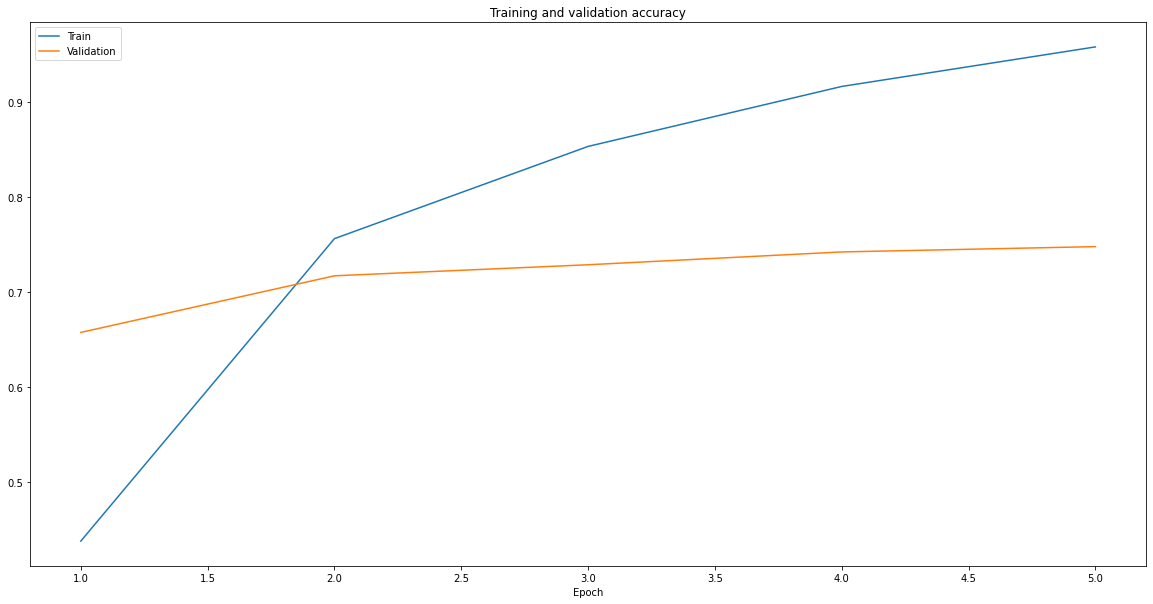

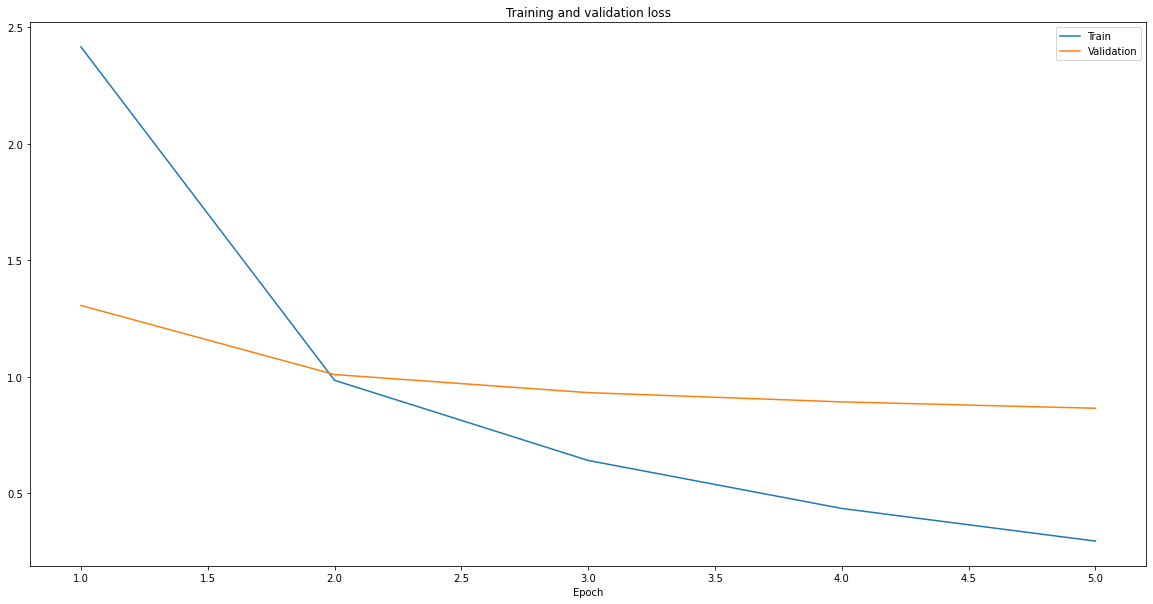

In [80]:
diagnostic_learning_curves(history3)

### faire l'inference avant 

In [ ]:
#ne pas executer
def test_set (image_size,batch_size):
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

    test_gen = test_datagen.flow_from_directory(
    path_test,
    target_size=image_size,  # All images  from the API will be resized to image_size
    batch_size=batch_size,
    shuffle=False)

    return (test_gen)

In [ ]:

inference3= inference (model3,test_set(image_size = (224,224),batch_size= 20))

Found 4162 images belonging to 120 classes.
Total True Positives for all classes : 2625.0
Total predictions for all classes : 4162
Accuracy of predictions for all classes : 63.1
accuracy.mean  65.9
accuracy.min 28.0
accuracy.max 97.0
accuracy.std 16.0


In [ ]:
#cree la dir ou mettre cet excel : datasets
history3.to_csv(path_source+'/lossacc-Model3_percent.csv') 

inference3.to_excel(path_source+'/dogssAccuracy-Model3_percent.xlsx')

## predict an image with ImageNet

In [ ]:
#set path of the image 

def prepare_image(file):
    img_path = 'data/MobileNet-samples/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

## testing 

*source de cette fn : *https://deeplizard.com/learn/video/OO4HD-1wRN8

In [94]:
def process_imgs (file, target_size = (224, 224)):
  img_path = path_datasets +'/data/MobileNet-samples' 
  img = image.load_img(img_path + file , target_size)
  if img.mode !="RGB":
     img = img.convert("RGB")
  img_array = image.img_to_array(img)
  img_array_expanded_dims = np.expand_dims(img_array, axis=0)
  return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

source fn : prepare image :
https://stackoverflow.com/questions/50906123/nameerror-name-image-is-not-defined/50906222

In [84]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

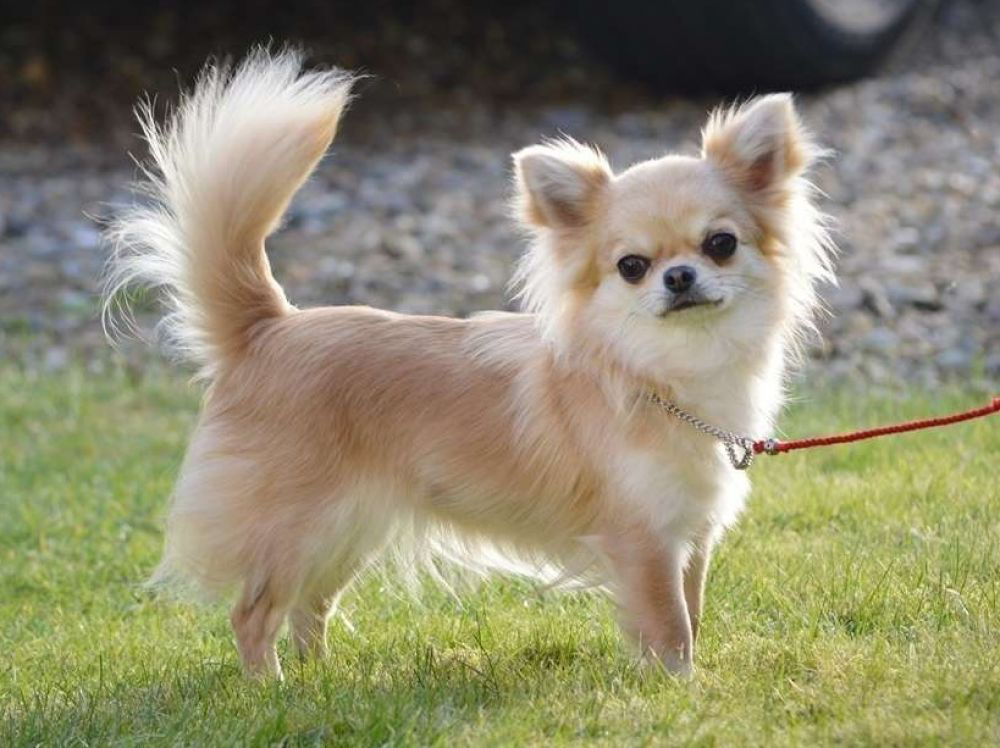

In [96]:
chien_test1_tf = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/datasets/data/MobileNet-samples/chien_test1.jpg')
chien_test1_tf

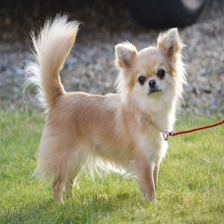

In [99]:
chien_test1 = chien_test1_tf.resize((224, 224))
chien_test1

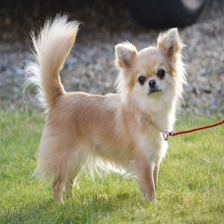

In [102]:
chien_test1.save("/content/drive/MyDrive/datasets/data/MobileNet-samples/chien_test1.jpg")
chien_test1

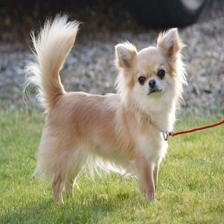

In [103]:
#try an image 
#cree ton dossier sample images 
from IPython.display import Image #cree le path des images sample
Image(filename='/content/drive/MyDrive/datasets/data/MobileNet-samples/chien_test1.jpg', width=300,height=200) #set witdth and height

In [126]:
processed_image = process_imgs('/chien_test1.jpg')
predictions = model3.predict(processed_image).T

 Then, we're using an ImageNet utility function provided by Keras called decode_predictions(). It returns the top five ImageNet class predictions with the ImageNet class ID, the class label, and the probability. With this, we'll be able to see the five ImageNet classes with the highest prediction probabilities from our model on this given image. Recall that there are 1000 total ImageNet classes.

results = imagenet_utils.decode_predictions(predictions)

In [127]:
results = imagenet_utils.decode_predictions(predictions)
#reecrire le resultat ici avec cette fn

ValueError: ignored

In [111]:
predictions.shape

(120, 1)

In [112]:
predictions

array([[2.69513430e-06],
       [6.54319010e-05],
       [2.73117564e-07],
       [1.37747884e-06],
       [1.90541014e-05],
       [4.93141590e-04],
       [2.26750672e-07],
       [2.50339281e-06],
       [2.74855224e-03],
       [3.83389881e-04],
       [3.64736006e-05],
       [2.82791029e-06],
       [5.68518487e-07],
       [4.11001919e-03],
       [9.56897838e-06],
       [4.34444482e-05],
       [7.52728056e-07],
       [3.17449749e-01],
       [3.84519342e-04],
       [2.24412770e-06],
       [4.74445687e-06],
       [7.01483950e-05],
       [4.32698971e-06],
       [5.04580657e-06],
       [5.00036331e-05],
       [2.71590106e-05],
       [6.20354040e-05],
       [1.02399031e-06],
       [4.31570770e-05],
       [1.51971449e-06],
       [4.00186809e-06],
       [2.08012943e-06],
       [6.09957460e-05],
       [1.67757989e-05],
       [8.24057770e-06],
       [8.74951922e-07],
       [2.14077568e-06],
       [7.22220375e-06],
       [5.77496784e-03],
       [2.89005783e-07],


In [115]:

prediction = np.argmax(predictions[0])
pred3 = np.argsort(predictions)


In [118]:
pred3_df = pd.DataFrame(predictions)


In [119]:
pred3_df['labels']= races_


In [120]:
##
pred3_df['labels']= races_
pred3_df.columns = ['Proba','labels']

In [128]:
# proba que test_chien soit : 
pred3_df.sort_values('Proba',ascending= False).head(10)

Proba                   labels
53   0.493292               otterhound
17   0.317450                    boxer
107  0.156622                    Lhasa
38   0.005775           Sussex_spaniel
51   0.004222      African_hunting_dog
13   0.004110       miniature_pinscher
8    0.002749     Old_English_sheepdog
73   0.002626                   borzoi
52   0.002626         English_foxhound
91   0.001475  wire-haired_fox_terrier

In [125]:
pred3

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

#use the model for inference 

In [131]:
history3.history

{'accuracy': [0.438174843788147,
  0.7561824917793274,
  0.8531522154808044,
  0.9161964654922485,
  0.9577847719192505],
 'loss': [2.416529417037964,
  0.9852835536003113,
  0.6412177681922913,
  0.4351593852043152,
  0.29506537318229675],
 'val_accuracy': [0.6576011180877686,
  0.7171083092689514,
  0.7287307977676392,
  0.7422129511833191,
  0.7477917075157166],
 'val_loss': [1.3066530227661133,
  1.0100499391555786,
  0.932364284992218,
  0.892673671245575,
  0.8653155565261841]}

In [132]:
history3_df = pd.DataFrame(history3.history)
history3_df 

loss  accuracy  val_loss  val_accuracy
0  2.416529  0.438175  1.306653      0.657601
1  0.985284  0.756182  1.010050      0.717108
2  0.641218  0.853152  0.932364      0.728731
3  0.435159  0.916196  0.892674      0.742213
4  0.295065  0.957785  0.865316      0.747792

In [133]:
#lire la fn de confusion matrix avant 
predictions = model3.predict(x = test_gen,steps=len(test_gen),verbose=0)


In [134]:
#confusion matrix

cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [135]:
test_gen.class_indices

{'Afghan_hound': 0,
 'African_hunting_dog': 1,
 'Airedale': 2,
 'American_Staffordshire_terrier': 3,
 'Appenzeller': 4,
 'Australian_terrier': 5,
 'Bedlington_terrier': 6,
 'Bernese_mountain_dog': 7,
 'Blenheim_spaniel': 8,
 'Border_collie': 9,
 'Border_terrier': 10,
 'Boston_bull': 11,
 'Bouvier_des_Flandres': 12,
 'Brabancon_griffon': 13,
 'Brittany_spaniel': 14,
 'Cardigan': 15,
 'Chesapeake_Bay_retriever': 16,
 'Chihuahua': 17,
 'Dandie_Dinmont': 18,
 'Doberman': 19,
 'English_foxhound': 20,
 'English_setter': 21,
 'English_springer': 22,
 'EntleBucher': 23,
 'Eskimo_dog': 24,
 'French_bulldog': 25,
 'German_shepherd': 26,
 'German_short-haired_pointer': 27,
 'Gordon_setter': 28,
 'Great_Dane': 29,
 'Great_Pyrenees': 30,
 'Greater_Swiss_Mountain_dog': 31,
 'Ibizan_hound': 32,
 'Irish_setter': 33,
 'Irish_terrier': 34,
 'Irish_water_spaniel': 35,
 'Irish_wolfhound': 36,
 'Italian_greyhound': 37,
 'Japanese_spaniel': 38,
 'Kerry_blue_terrier': 39,
 'Labrador_retriever': 40,
 'Lakelan

In [136]:
cm_plot_labels = [test_gen.class_indices]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, normalize=False,title='confusion matrix')

Confusion matrix, without normalization
[[12  0  1 ...  0  0  0]
 [ 0 11  0 ...  0  1  0]
 [ 0  0 17 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  1 13  0]
 [ 0  0  2 ...  0  0  9]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


In [137]:
plot_confusion_matrix(cm, classes =[races_] )

Confusion matrix, without normalization
[[12  0  1 ...  0  0  0]
 [ 0 11  0 ...  0  1  0]
 [ 0  0 17 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  1 13  0]
 [ 0  0  2 ...  0  0  9]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


##COMMENTAIRES:
Le modèle n'est pas précis 

- pistes d'amélioration :
>réduire la learning rate 

>augmenter  encore les données du train set

>early-stopping, pour trouver le nombre d'epochs juste 

>faire de l'hyperoptimisation

>après validation , mélanger le train et validation avant le test

>abandon de VGG16 réseau trop grand pour le jeu de données


# tranfert learning , VVG16, ResNet

---
https://learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/


---

 Now, while MobileNets are faster and smaller than other major networks, like VGG16, for example, there is a tradeoff. That tradeoff is accuracy, but don't let this discourage you.

Yes, MobileNets typically aren't as accurate as these other large, resource-heavy models, but they still actually perform very well, with really only a relatively small reduction in accuracy.

#inference M6 : vgg16

MobileNet a plus de couche que VVG, EVALUONS vvg

In [ ]:
train_datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=path_train, target_size=(224,224), class_mode='categorical', batch_size=20)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=path_valid, target_size=(224,224), class_mode='categorical', batch_size=20)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory=path_test,target_size=(224,224),class_mode='categorical',batch_size=20, shuffle = False )



Found 12307 images belonging to 120 classes.
Found 4111 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.


In [ ]:
from  tensorflow.keras.applications.vgg16 import VGG16
from  tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
from  tensorflow.keras.applications.vgg16 import VGG16
vgg16_model= VGG16()


In [ ]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
############

In [ ]:
model6 = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [ ]:
#This freezes the weights and other trainable parameters in each layer so that they will not be trained 
#or updated when we later pass in our images 

for layer in model.layers:
    layer.trainable = False

In [ ]:
#we add our new output
model6.add(Dense(units=120, activation='softmax'))

In [ ]:
model6.summary()

In [ ]:
#lower lr because we are doing tranfert learning 

model6.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history6=model6.fit(x=train_datagen,
            steps_per_epoch=len(train_datagen),#
            validation_data=val_datagen,
            validation_steps=len(val_datagen),#batch_size
            epochs=5,
            verbose=2)

#Deploy in streamlit

In [7]:
#upgrade the python kernel
!pip install -U ipykernel

Requirement already up-to-date: ipykernel in /usr/local/lib/python3.7/dist-packages (5.5.0)


In [8]:
#install the app streamlit
!pip install -q streamlit

     |████████████████████████████████| 7.0MB 5.6MB/s 
     |████████████████████████████████| 163kB 56.8MB/s 
     |████████████████████████████████| 4.6MB 48.0MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 112kB 60.2MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 


In [10]:
#pyngrok to expose my ip address : binding my IP adress of drive with an external address
#acces to my app on internet , pyngrok, bind my address with the one it creating
!pip install pyngrok

In [11]:
#register an id , and get an automatically created token :copy past here
!ngrok authtoken 1qFHKkcGetwfc7v3Ra9eUm0Gxzi_8a7kmsswKMjCUFcJskoft

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [15]:
#magic fn , that call my model 

%%writefile score.py

import tensorflow as tf
import numpy as np
import streamlit as st
from PIL import Image
import requests
from io import BytesIO #data saved as bytes
import os
import re

st.set_option('deprecation.showfileUploaderEncoding', False) #desable the duplication commands,or warning...
st.title("Welcome to the Dogs breeds Classifier created by Doriane")
st.text("Provide URL of dogs Image for breeds classification")

@st.cache(allow_output_mutation=True)#not loading the model all time,this cache it
def load_model():
  model = tf.keras.models.load_model('/content/my_model3_percent')#path of the model
  return model

with st.spinner('Loading Model Into Memory....'):#spinner shows that the model is loaded
  model = load_model()

classes = [re.sub("n[0-9]*-", "", file_breed.name) for file_breed in os.scandir("/content/drive/MyDrive/datasets/Images/") if file_breed.is_dir()]

def scale(image): #pixel:(0,1)
  image = tf.cast(image, tf.float32)
  image /= 255.0 #resize, for the accepted images of mobileNet

  return tf.image.resize(image,[224,224])

#take the images , extend it (more than the batch dimension)
#adding one dimension(224,224,3)
def decode_img(image):
  img = tf.image.decode_jpeg(image, channels=3)
  img = scale(img)
  return np.expand_dims(img, axis=0)

path = st.text_input('Enter Image URL to Classify.. ','http://barmac.com.au/wp-content/uploads/sites/3/2016/01/Angular-Leaf-Spot-Beans1.jpg')
if path is not None:
    content = requests.get(path).content

    st.write("Predicted Class :")
    with st.spinner('classifying.....'):
      label =np.argmax(model.predict(decode_img(content)),axis=1)
      st.write(classes[label[0]])    
    st.write("")
    image = Image.open(BytesIO(content))
    st.image(image, caption='Classifying dogs breed ', use_column_width=True)

Overwriting score.py


In [16]:
!nohup streamlit run --server.port 80 score.py & #launch app on port 80

nohup: appending output to 'nohup.out'


In [17]:
from pyngrok import ngrok

url = ngrok.connect(port=8501)
url

<NgrokTunnel: "http://6f07d97bb5b4.ngrok.io" -> "http://localhost:80">

In [ ]:
!cat nohup.out #pas de logs 

In [ ]:
#predire
# https://images.dog.ceo/breeds/terrier-american/n02093428_592.jpg